In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation, ReLU
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [2]:
data_path = "D:\TeachMeSkills\lk39"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 63593 files belonging to 1 classes.


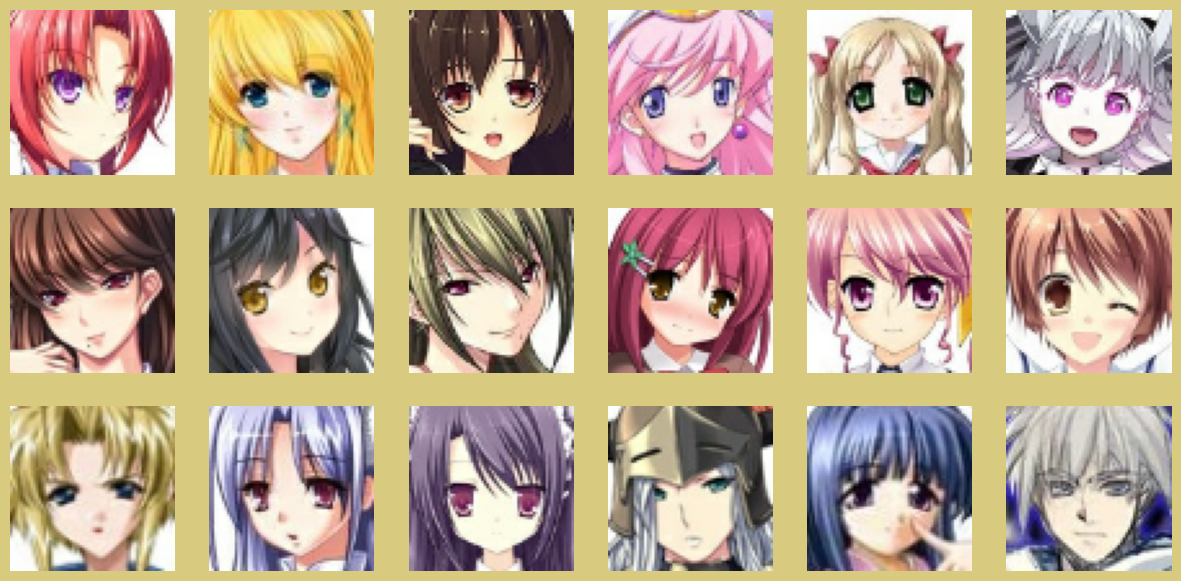

In [3]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

In [4]:
data = data.map(lambda x: x / 255.0)
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

Генератор

In [5]:
    generator = Sequential()
    generator.add(Dense(4*4*256, activation='relu', input_dim = 100))
    generator.add(Reshape((4,4,256)))
    
        
    generator.add(Conv2DTranspose(filters = 512, kernel_size = 2,strides = (2,2), padding = "valid"))
    generator.add(BatchNormalization(momentum = 0.5))
    generator.add(Activation(LeakyReLU(0.2)))
    
    
    generator.add(Conv2DTranspose(filters = 256, kernel_size = 4,strides = (2,2), padding = "same"))
    generator.add(BatchNormalization(momentum = 0.5))
    generator.add(Activation(LeakyReLU(0.2)))
   
    
    generator.add(Conv2DTranspose(filters = 128, kernel_size = 4,strides = (2,2), padding = "same"))
    generator.add(BatchNormalization(momentum = 0.5))
    generator.add(Activation(LeakyReLU(0.2)))
      
    generator.add(Conv2DTranspose(filters = 64, kernel_size = 4,strides = (2,2), padding = "same"))
    generator.add(BatchNormalization(momentum = 0.5))
    generator.add(Activation(LeakyReLU(0.2)))
    
    generator.add(Conv2D(filters = 64, kernel_size = 3,strides = (1,1), padding = "same"))
    generator.add(BatchNormalization(momentum = 0.5))
    generator.add(Activation(LeakyReLU(0.2)))
    
    generator.add(Conv2DTranspose(filters = 3, kernel_size = 4, strides = (1,1),  padding = "same"))
    generator.add(Activation("tanh"))
   

In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        524800    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      2

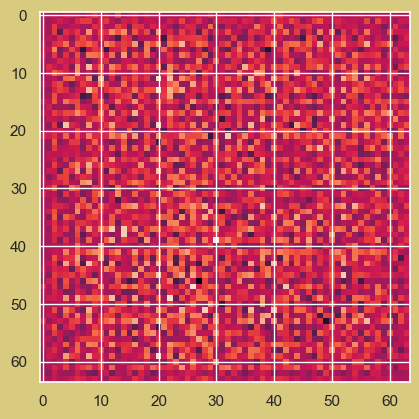

In [7]:
seed = tf.random.normal((1, 100))
gen = generator(seed, training=False)
plt.imshow(gen[0,:,:,0])

Дискриминатор

In [8]:
    discriminator = Sequential()
        
    discriminator.add(Conv2D(filters = 64, kernel_size = 4, strides = 2, input_shape=(64,64,3), padding = "same"))
    discriminator.add(Activation(LeakyReLU(alpha=0.2)))
    
    discriminator.add(Conv2D(filters = 128, kernel_size = 4, strides = 2,  padding = "same"))
    discriminator.add(BatchNormalization(momentum = 0.5))
    discriminator.add(Activation(LeakyReLU(alpha=0.2)))
    
    discriminator.add(Conv2D(filters = 256, kernel_size = 4, strides = 2,  padding = "same"))
    discriminator.add(BatchNormalization(momentum = 0.5))
    discriminator.add(Activation(LeakyReLU(alpha=0.2)))
    
    discriminator.add(Conv2D(filters = 512, kernel_size = 4, strides = 2,  padding = "same"))
    discriminator.add(BatchNormalization(momentum = 0.5))
    discriminator.add(Activation(LeakyReLU(alpha=0.2)))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 activation_6 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         524544    
                                                      

In [10]:
verd=discriminator(gen)
print(verd)

tf.Tensor([[0.5000179]], shape=(1, 1), dtype=float32)


In [11]:
class gan(tf.keras.Model):
    def __init__(self, discriminator, generator, dim):
        super(gan, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.dim = dim
    def compile(self, d_opt, g_opt, loss_fn):
        super(gan, self).compile()
        self.d_opt = d_opt
        self.g_opt = g_opt
        self.loss_fn = loss_fn
        self.d_loss_metrics = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metrics = tf.keras.metrics.Mean(name='g_loss')
    
    @property
    def metrics(self):
        return [self.d_loss_metrics, self.g_loss_metrics]
    
    def train_step(self, real_img):
        batch_size = tf.shape(real_img)[0]
        seed = tf.random.normal(shape = (batch_size, self.dim))
        
        generated_img = self.generator(seed)
        
        combi_img = tf.concat([generated_img, real_img], axis = 0)
        
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis = 0)
        labels += 0.05* tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predict = self.discriminator(combi_img)
            d_loss = self.loss_fn(labels, predict)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        seed = tf.random.normal(shape=(batch_size, self.dim))
        
        mis_labels = tf.zeros((batch_size,1))
        
        with tf.GradientTape() as tape:
            predict = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(mis_labels, predict)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        
        self.d_loss_metrics.update_state(d_loss)
        self.g_loss_metrics.update_state(g_loss)
        return {'d_loss': self.d_loss_metrics.result(), 'g_loss': self.g_loss_metrics.result()}

In [12]:
epochs = 10

discriminator_opt = tf.keras.optimizers.Adamax(1.0e-4, 0.5)
generator_opt = tf.keras.optimizers.Adamax(1.8e-4, 0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = gan(discriminator = discriminator, generator = generator, dim=100)
model.compile(d_opt=discriminator_opt, g_opt=generator_opt, loss_fn = loss_fn)

history = model.fit(data, epochs=epochs)

Epoch 1/10
994/994 [==============================] - 341s 339ms/step - d_loss: 0.6320 - g_loss: 0.8744
Epoch 2/10
994/994 [==============================] - 330s 331ms/step - d_loss: 0.5506 - g_loss: 1.1564
Epoch 3/10
994/994 [==============================] - 324s 325ms/step - d_loss: 0.6148 - g_loss: 1.0491
Epoch 4/10
994/994 [==============================] - 323s 325ms/step - d_loss: 0.6005 - g_loss: 1.1036
Epoch 5/10
994/994 [==============================] - 323s 325ms/step - d_loss: 0.6346 - g_loss: 1.0583
Epoch 6/10
994/994 [==============================] - 320s 321ms/step - d_loss: 0.6375 - g_loss: 1.0126
Epoch 7/10
994/994 [==============================] - 310s 312ms/step - d_loss: 0.6140 - g_loss: 1.0880
Epoch 8/10
994/994 [==============================] - 323s 325ms/step - d_loss: 0.6163 - g_loss: 1.0805
Epoch 9/10
994/994 [==============================] - 323s 325ms/step - d_loss: 0.6359 - g_loss: 1.0096
Epoch 10/10
994/994 [==============================] - 323s 325m

In [13]:
num_img = 16
gen_ar = []
seed = tf.random.normal([num_img, 100])
generated_img = generator(seed)
generated_img = generated_img.numpy()
for i in range(num_img):
    img = tf.keras.preprocessing.image.array_to_img(generated_img[i])
    gen_ar.append(img)

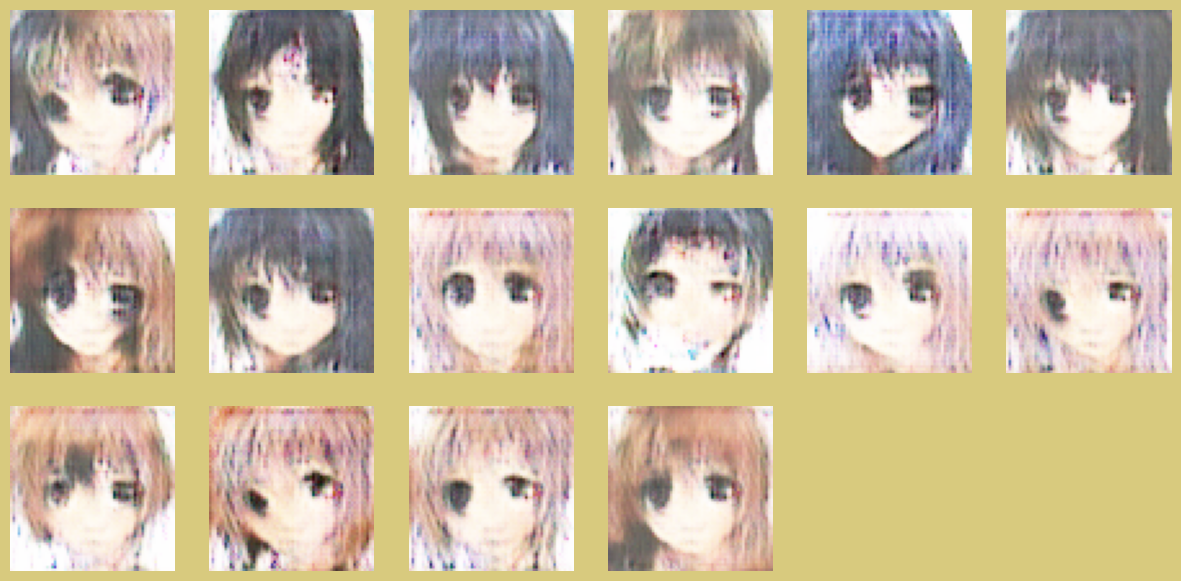

In [14]:
plt.figure(figsize=(15,15))
for i in range(len(gen_ar)):
    ax = plt.subplot(6, 6, i + 1)
    ax.imshow(gen_ar[i])
    ax.axis("off")